
# time-series-project

1. Install yahoo finance library (yfinance)
2. Retrieve stock price data
3. Choose any ticker symbol and you can choose “Open” or “Close” price for this project<sup>[1](#myfootnote1)</sup> <sup>[2](#myfootnote2)</sup>
4. Analyse time series<sup>[3](#myfootnote3)</sup>
5. Check for seasonality
6. Train time series model
7. Find the best hyperparameter values of (P, D, Q) with the smallest RMSE for building an ARIMA model<sup>[4](#myfootnote4)</sup>
8. Predict price for the next time period (Maybe two Timestamps)
9. Save timestamp, prediction and actual price to a database

❗ BONUS: Deploy your model to Streamlit.  
a. The app should pull fresh data from the web through yfinance  
b. The user should be able to define a forecasting window (how far ahead they want the forecast)  

❗❗ Extra Super Hard BONUS!! Allow the user to choose the ticker symbol to look up and get predictions for.   
HINT: you'll need to refit the model. This may be hard without determining again the P, D, and Q

<a name="myfootnote1">1</a>: The program should only run between 8am and 4pm ET  
<a name="myfootnote2">2</a>: The data period and interval should be 1 year and 1 hour respectively  
<a name="myfootnote3">3</a>: Choose the last 50 records as your test data for the purpose of saving time  
<a name="myfootnote4">4</a>: Please set the hyperparameter values of (P, D, Q) within these ranges also for the purpose of saving time: For “P”: 1 ≦ P ≦ 3 For “D”: 0 ≦ D ≦ 2 For “Q”: 0 ≦ Q ≦ 2


In [28]:
# Base Imports

import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_formats='retina'

plt.style.use("ggplot")

import numpy as np
import pandas as pd

import warnings

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tools.sm_exceptions import InterpolationWarning

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter("ignore", InterpolationWarning)

from sklearn.preprocessing import power_transform
from sklearn import set_config

set_config(transform_output="pandas")


# ADF test is used to determine the presence of unit root in the series, and hence helps in understand if the series is stationary or not. The null and alternate hypothesis of this test are:
# Null Hypothesis: The series has a unit root.
# Alternate Hypothesis: The series has no unit root.
# If the null hypothesis fails to be rejected, this test may provide evidence that the series is non-stationary.
def adf_test(timeseries, autolag="AIC"):
    from statsmodels.tsa.stattools import adfuller

    # "AIC" (Akaike Information Criterion):
    # This option selects the lag length that minimizes the AIC.
    # The AIC is a measure that balances the goodness of fit of a statistical model with its complexity.
    # Lower AIC values generally indicate a better model.
    # "BIC" (Bayesian Information Criterion):
    # Similar to AIC, this option chooses the lag length that minimizes the BIC.
    # The BIC also balances model fit and complexity, but it tends to penalize complex models more heavily than the AIC.
    # "t-stat" (t-statistic):
    # This method starts with the maximum lag length (maxlag) and iteratively reduces it.
    # It stops when the t-statistic of the last lag becomes statistically significant (typically at a 5% significance level).
    # This approach focuses on the statistical significance of the individual lags.
    dftest = adfuller(
        timeseries.dropna(), 
        autolag=autolag, )
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value

    dfoutput[autolag] = dftest[5]

    dfoutput.name = "Results of Dickey-Fuller Test"

    if (dftest[1] < 0.05) & (dftest[4]["5%"] > dftest[0]):
        print(
            "\u001b[32mConclusion: The data is stationary (Reject the null hypothesis)\u001b[0m"
        )
    else:
        print(
            "\x1b[31mConclusion: The data is not stationary (Fail to reject the null hypothesis)\x1b[0m"
        )
    return dfoutput


# KPSS is another test for checking the stationarity of a time series. The null and alternate hypothesis for the KPSS test are opposite that of the ADF test.
# Null Hypothesis: The process is trend stationary.
# Alternate Hypothesis: The series has a unit root (series is not stationary).
def kpss_test(timeseries, regression="c"):
    from statsmodels.tsa.stattools import kpss

    kpsstest = kpss(timeseries.dropna(), regression=regression, nlags="auto")
    kpssoutput = pd.Series(
        kpsstest[0:3], index=["Test Statistic", "p-value", "Lags Used"]
    )
    for key, value in kpsstest[3].items():
        kpssoutput["Critical Value (%s)" % key] = value

    kpssoutput.name = "Results of KPSS Test"

    if (kpsstest[1] < 0.05) & (kpsstest[3]["5%"] > kpsstest[0]):
        print(
            "\x1b[31mConclusion: The data is not stationary (Reject the null hypothesis)\x1b[0m"
        )

    else:
        print(
            "\u001b[32mConclusion: The data is stationary (Fail to reject the null hypothesis)\u001b[0m"
        )

    return kpssoutput


def add_stl_plot(fig, res, legend):
    """Add 3 plots from a second STL fit"""
    axs = fig.get_axes()
    comps = ["trend", "seasonal", "resid"]
    for ax, comp in zip(axs[1:], comps):
        series = getattr(res, comp)
        if comp == "resid":
            ax.plot(series, marker="o", linestyle="none")
        else:
            ax.plot(series)
            if comp == "trend":
                ax.legend(legend, frameon=False)


In [29]:
# Install yahoo finance library (yfinance)
# %conda install yfinance

import yfinance as yf

# # Now you can use yfinance functions
# dat = yf.Ticker("MSFT")
# dat.info
# dat.calendar
# dat.analyst_price_targets
# dat.quarterly_income_stmt
# dat.history(period='1mo')
# dat.option_chain(dat.options[0]).calls

# Choose stock

In [30]:
# Retrieve stock price data
# Choose any ticker symbol and you can choose “Open” or “Close” price for this project

# hoping to build model for
# tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'JNJ', 'XOM', 'V', 'WMT', 'NVDA', 'PG',
#             'LLY', 'CVX', 'MA', 'HD', 'PFE', 'ABBV', 'MRK', 'KO', 'PEP', 'AVGO', 'ORCL',
#             'TMO', 'AZN', 'CSCO', 'DHR', 'MCD', 'ABT', 'TMUS', 'ACN', 'NEE', 'VZ', 'TTE',
#             'LIN', 'DIS', 'PM', 'BMY', 'CMCSA', 'SCHW', 'UPS', 'TXN', 'RTX', 'COP']
# will start with 'AAPl'


from datetime import datetime

# 1. Define the ticker and date range
tickers = ["AAPL"]
end_date = datetime.today().strftime('%Y-%m-%d')

start_date = (pd.to_datetime(end_date) - pd.DateOffset(years=1)).strftime('%Y-%m-%d')  # 1 year before

# 2. Download data from yfinance
yf_dl = yf.download(
    tickers,
    start=start_date,
    end=end_date,
    actions=False,
    threads=True,
    ignore_tz=None,
    group_by="column",
    auto_adjust=True,
    back_adjust=False,
    repair=False,
    keepna=False,
    progress=True,
    # period="1y",
    interval="1h",
    prepost=False,
    proxy=None,
    rounding=False,
    timeout=10,
    session=None,
    multi_level_index=False,
)

yf_dl.head(35)

[*********************100%***********************]  1 of 1 completed


,Close,High,Low,Open,Volume
Datetime,,,,,
2024-04-08 13:30:00+00:00,168.820007,169.190002,168.240005,169.059998,8279940
2024-04-08 14:30:00+00:00,168.815002,169.130005,168.649994,168.824997,4718366
2024-04-08 15:30:00+00:00,168.412399,168.815002,168.264999,168.815002,4134102
2024-04-08 16:30:00+00:00,168.645004,168.835007,168.404999,168.414993,2982857
2024-04-08 17:30:00+00:00,168.790100,168.899994,168.470001,168.645004,2336490
2024-04-08 18:30:00+00:00,168.785004,168.799896,168.544998,168.794998,2798561
2024-04-08 19:30:00+00:00,168.460007,168.960007,168.324997,168.785004,4991117
2024-04-09 13:30:00+00:00,169.470001,170.074997,168.500000,168.692001,9892473
2024-04-09 14:30:00+00:00,168.695007,169.490005,168.479996,169.475006,5975622


In [31]:
# # Analyse time series

# from pandas.tseries.offsets import Minute, BusinessHour
# fifteen_min = Minute(n=15)

# # yf_dl = yf_dl.resample(BusinessHour) # resample by business hour
# yf_dl.index.freq = BusinessHour
# yf_dl.head(24)

In [32]:
timeseries = yf_dl["Close"]
timeseries

Datetime
2024-04-08 13:30:00+00:00    168.820007
2024-04-08 14:30:00+00:00    168.815002
2024-04-08 15:30:00+00:00    168.412399
2024-04-08 16:30:00+00:00    168.645004
2024-04-08 17:30:00+00:00    168.790100
                                ...    
2025-04-04 15:30:00+00:00    192.809998
2025-04-04 16:30:00+00:00    190.990005
2025-04-04 17:30:00+00:00    188.880005
2025-04-04 18:30:00+00:00    190.229996
2025-04-04 19:30:00+00:00    188.380005
Name: Close, Length: 1738, dtype: float64

In [33]:
from scipy.signal import periodogram, find_peaks

# Compute power spectrum
frequencies, power = periodogram(timeseries.dropna())
# Find peaks in the power spectrum
peaks, _ = find_peaks(power, height=0.1 * max(power))  # Tune height threshold
# Convert frequency to period
periods = 1 / frequencies[peaks]

periods

array([1738.])

In [34]:
adf_test(timeseries).round(6)

Conclusion: The data is not stationary (Fail to reject the null hypothesis)


Test Statistic                   -2.061815
p-value                           0.260144
#Lags Used                        7.000000
Number of Observations Used    1730.000000
Critical Value (1%)              -3.434136
Critical Value (5%)              -2.863212
Critical Value (10%)             -2.567660
AIC                            6137.987214
Name: Results of Dickey-Fuller Test, dtype: float64

In [35]:
kpss_test(timeseries)

Conclusion: The data is stationary (Fail to reject the null hypothesis)


Test Statistic            3.881619
p-value                   0.010000
Lags Used                26.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
Name: Results of KPSS Test, dtype: float64

In [36]:
adf_lags_used = adf_test(timeseries).iloc[2] # lags used by ADF test
adf_lags_used += 1 # need to add lag 0 to complete the period
period = adf_lags_used.astype(int) # convert to int

if period < 7:
    period = 35
else:
    period = period

Conclusion: The data is not stationary (Fail to reject the null hypothesis)


In [37]:
from statsmodels.tsa.seasonal import STL

seasonal = period + ((period % 2) == 0)  # Ensure odd
seasonal_jump = int(np.ceil(0.15 * (period + 1)))
low_pass_jump = int(np.ceil(0.15 * (period + 1))) # must be a positive integer
trend_jump = int(np.ceil(0.15 * 1.5 * (period + 1)))

if low_pass_jump < 1:
    low_pass_jump = 1
else:
    low_pass_jump = low_pass_jump

if seasonal_jump < 1:
    seasonal_jump = 1
else:
    seasonal_jump = seasonal_jump



mod = STL(
    timeseries,
    period=period,
    seasonal=seasonal,
    seasonal_deg=1, 
    trend_deg=1, 
    low_pass_deg=1, 
    robust=True,
    seasonal_jump=seasonal_jump,
    trend_jump=trend_jump,
    low_pass_jump=low_pass_jump,
)

In [38]:
# Import seasonal_decompose
from statsmodels.tsa.seasonal import seasonal_decompose

# Check for seasonality
decomposition = seasonal_decompose(
    timeseries.dropna(), 
    model="additive", 
    filt=None, 
    period=period, 
    two_sided=False, 
    extrapolate_trend="freq"
)

seasonals = decomposition.seasonal
trends = decomposition.trend

no_seasonal_trend = timeseries - trends

timeseries_cleaned = no_seasonal_trend.clip(lower=0)

# timeseries_cleaned.plot()
# yf_dl.plot(y="Close")
# yf_dl.plot(y="Close_no_seasonal_trend")
# decomposition


In [39]:
adf_test(timeseries=timeseries_cleaned).round(6)

Conclusion: The data is stationary (Reject the null hypothesis)


Test Statistic                  -12.033341
p-value                           0.000000
#Lags Used                        7.000000
Number of Observations Used    1730.000000
Critical Value (1%)              -3.434136
Critical Value (5%)              -2.863212
Critical Value (10%)             -2.567660
AIC                            4131.534016
Name: Results of Dickey-Fuller Test, dtype: float64

In [40]:
kpss_test(timeseries=timeseries_cleaned)

Conclusion: The data is stationary (Fail to reject the null hypothesis)


Test Statistic            0.070996
p-value                   0.100000
Lags Used                20.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
Name: Results of KPSS Test, dtype: float64

In [41]:
# Train time series model

from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import train_test_split

train, test = train_test_split(
    timeseries_cleaned, 
    test_size=period, 
    shuffle=False
)
display(train.tail(period))
print(train.shape)
display(test.head(period))
print(test.shape)


Datetime
2025-04-02 18:30:00+00:00    0.190092
2025-04-02 19:30:00+00:00    0.056234
2025-04-03 13:30:00+00:00    0.000000
2025-04-03 14:30:00+00:00    0.000000
2025-04-03 15:30:00+00:00    0.000000
2025-04-03 16:30:00+00:00    0.000000
2025-04-03 17:30:00+00:00    0.000000
2025-04-03 18:30:00+00:00    0.000000
dtype: float64

(1730,)


Datetime
2025-04-03 19:30:00+00:00    0.0
2025-04-04 13:30:00+00:00    0.0
2025-04-04 14:30:00+00:00    0.0
2025-04-04 15:30:00+00:00    0.0
2025-04-04 16:30:00+00:00    0.0
2025-04-04 17:30:00+00:00    0.0
2025-04-04 18:30:00+00:00    0.0
2025-04-04 19:30:00+00:00    0.0
dtype: float64

(8,)


In [42]:
from statsmodels.tsa.stattools import acf, pacf


pacf_values = pacf(
    train, 
    nlags=None, 
    method="burg"
    )

acf_values = acf(
    train,
    adjusted=False, 
    nlags=None,
    qstat=False,
    fft=True,
    bartlett_confint=True,
    missing="none",
)

alpha = 0.05 # set our confidence at 5%
# iterate to set p and q as we would graphically
p = -1
for val in pacf_values:
    if np.abs(val) > alpha:
        p += 1
    else:
        break
if p > 0:
    p = p
else:
    p = 0

q = -1
for val in acf_values:
    if np.abs(val) > alpha:
        q += 1
    else:
        break
if q > 0:
    q = q
else:
    q = 0

In [43]:
# Find the best hyperparameter values of (P, D, Q) with the smallest RMSE for building an ARIMA model
# Please set the hyperparameter values of (P, D, Q) within these ranges also for the purpose of saving time:
# For “P”: 1 ≦ P ≦ 3 For “D”: 0 ≦ D ≦ 2 For “Q”: 0 ≦ Q ≦ 2

from sklearn.metrics import root_mean_squared_error
from statsmodels.tsa.arima.model import ARIMA

model_0 = ARIMA(
    train,
    exog=None,
    order=(p, 0, q),
    seasonal_order=(0, 0, 0, 0),
    trend="n",
    enforce_stationarity=False,
    enforce_invertibility=True,
    concentrate_scale=False,
    trend_offset=1,
    dates=None,
    freq=None,
    missing="none",
    validate_specification=True,
)

model_1 = ARIMA(
    train,
    exog=None,
    order=(p, 1, q),
    seasonal_order=(0, 0, 0, 0),
    trend="n",
    enforce_stationarity=False,
    enforce_invertibility=True,
    concentrate_scale=False,
    trend_offset=1,
    dates=None,
    freq=None,
    missing="none",
    validate_specification=True,
)

model_2 = ARIMA(
    train,
    exog=None,
    order=(p, 2, q),
    seasonal_order=(0, 0, 0, 0),
    trend="n",
    enforce_stationarity=False,
    enforce_invertibility=True,
    concentrate_scale=False,
    trend_offset=1,
    dates=None,
    freq=None,
    missing="none",
    validate_specification=True,
)

fitted_model_0 = model_0.fit()
fitted_model_1 = model_1.fit()
fitted_model_2 = model_2.fit()

/opt/anaconda3/envs/datascience/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/datascience/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/datascience/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/datascience/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency inform

In [44]:
# Predict price for the next time period (Maybe two Timestamps)
stock_forecast_0 = fitted_model_0.forecast(steps=len(test))
stock_forecast_1 = fitted_model_1.forecast(steps=len(test))
stock_forecast_2 = fitted_model_2.forecast(steps=len(test))

# test_results = pd.DataFrame(columns=["test", "test_forecast"])
# test_results["test"] = test
# test_results["test_forecast"] = stock_forecast

# Generate forecasts for the test period
# stock_forecast = fitted_model.forecast(steps=len(test))

# Create DataFrame with test and forecast values
test_results = pd.DataFrame(
    {"test": test, 
    "test_forecast_0": stock_forecast_0.iloc[0],
    "test_forecast_1": stock_forecast_1.iloc[0],
    "test_forecast_2": stock_forecast_2.iloc[0]
    }, index=test.index
)

/opt/anaconda3/envs/datascience/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/envs/datascience/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/envs/datascience/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


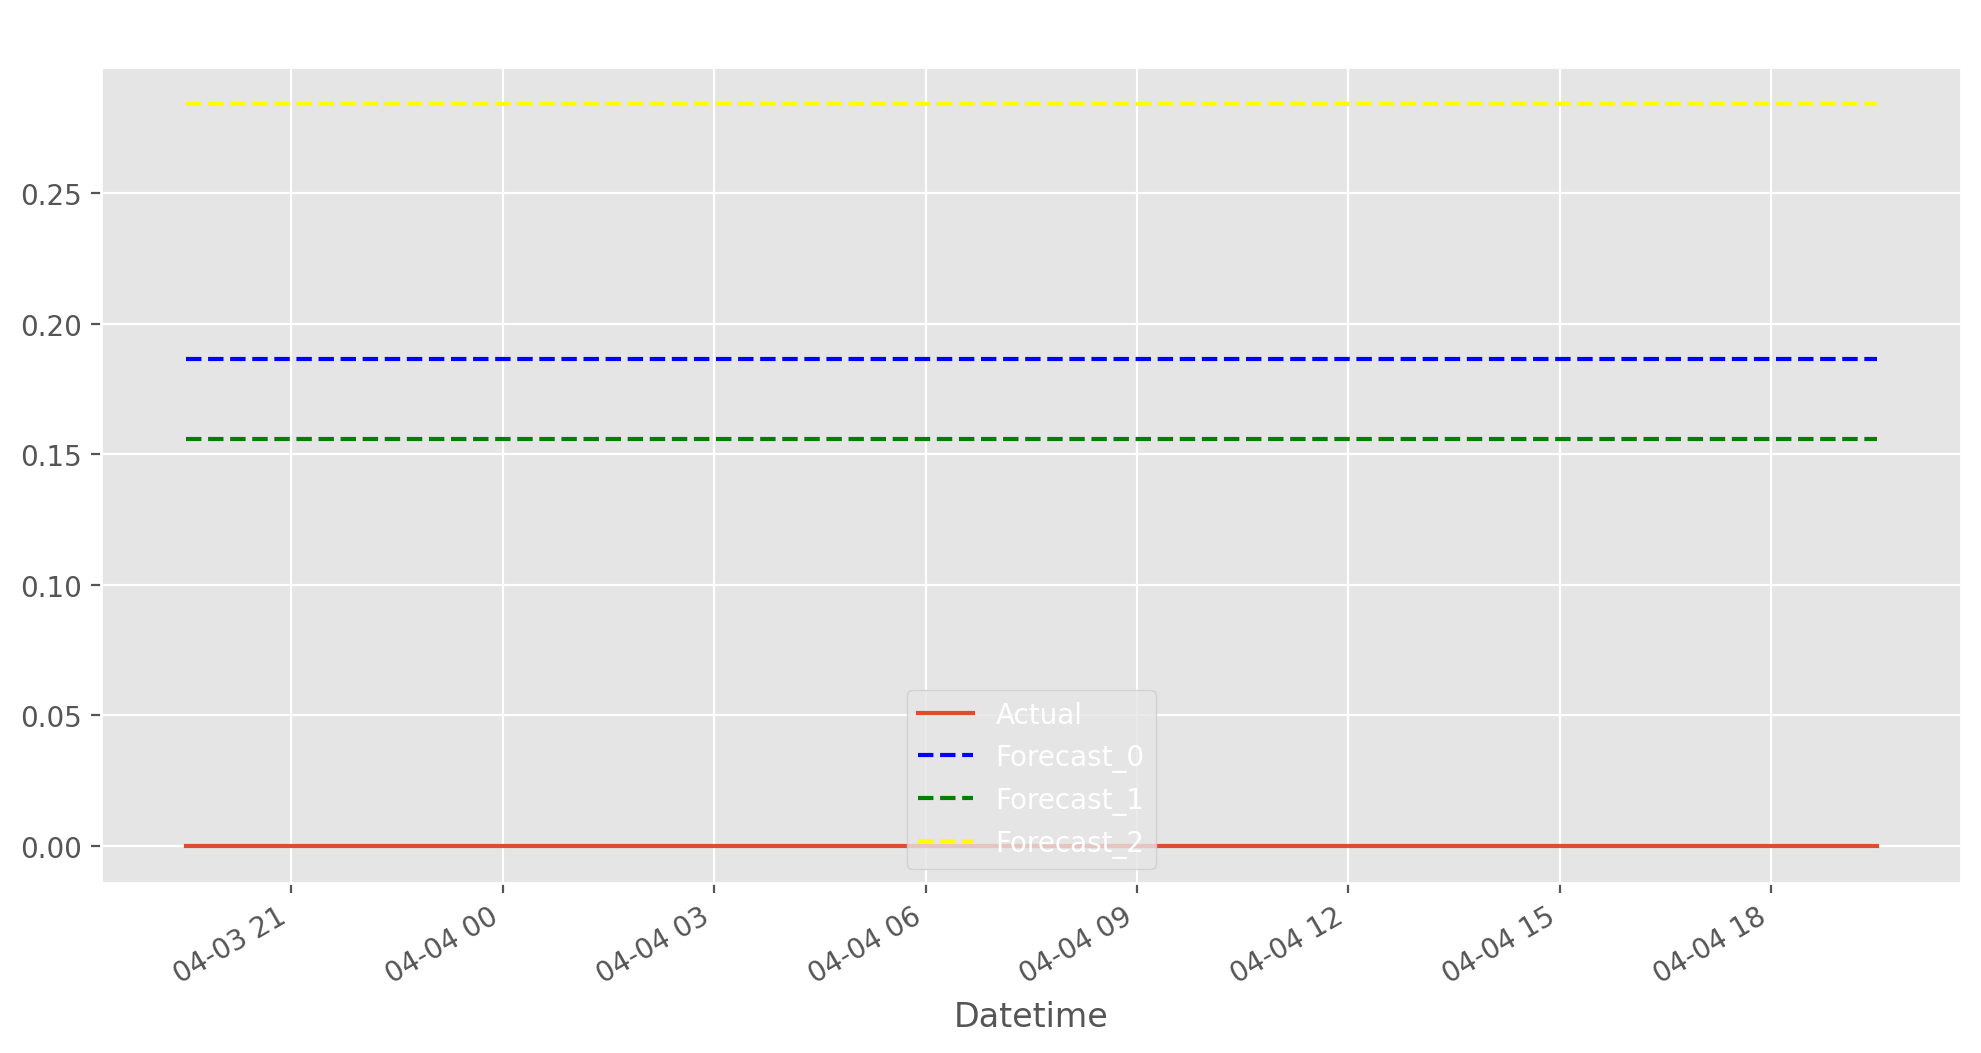

In [45]:
# Plot actual vs predicted values
fig, ax = plt.subplots(figsize=(12, 6))
test_results["test"].plot(label="Actual", ax=ax)
test_results["test_forecast_0"].plot(label="Forecast_0", ax=ax, style="--", color="blue")
test_results["test_forecast_1"].plot(label="Forecast_1", ax=ax, style="--", color="green")
test_results["test_forecast_2"].plot(label="Forecast_2", ax=ax, style="--", color="yellow")

plt.title("ARIMA Forecast vs Actual Values")
plt.legend()
plt.show()

# test_results.plot();

In [46]:
from pmdarima.arima import auto_arima

automatic = auto_arima(
    test,
    X=None,
    start_p=2,
    d=None,
    start_q=2,
    max_p=p+1,
    max_d=2,
    max_q=q+1,
    start_P=1,
    D=None,
    start_Q=1,
    max_P=2,
    max_D=1,
    max_Q=2,
    max_order=5,
    m=1,
    seasonal=True,
    stationary=False,
    information_criterion="hqic",
    alpha=0.05,
    test="adf",
    seasonal_test="ocsb",
    stepwise=True,
    n_jobs=1,
    start_params=None,
    trend=None,
    method="lbfgs",
    maxiter=50,
    offset_test_args=None,
    seasonal_test_args=None,
    suppress_warnings=True,
    error_action="trace",
    trace=False,
    random=False,
    random_state=None,
    n_fits=10,
    return_valid_fits=False,
    out_of_sample_size=0,
    scoring="mse",
    scoring_args=None,
    with_intercept="auto",
    sarimax_kwargs=None)


/opt/anaconda3/envs/datascience/lib/python3.12/site-packages/pmdarima/arima/auto.py:444: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '


<Axes: xlabel='Datetime'>

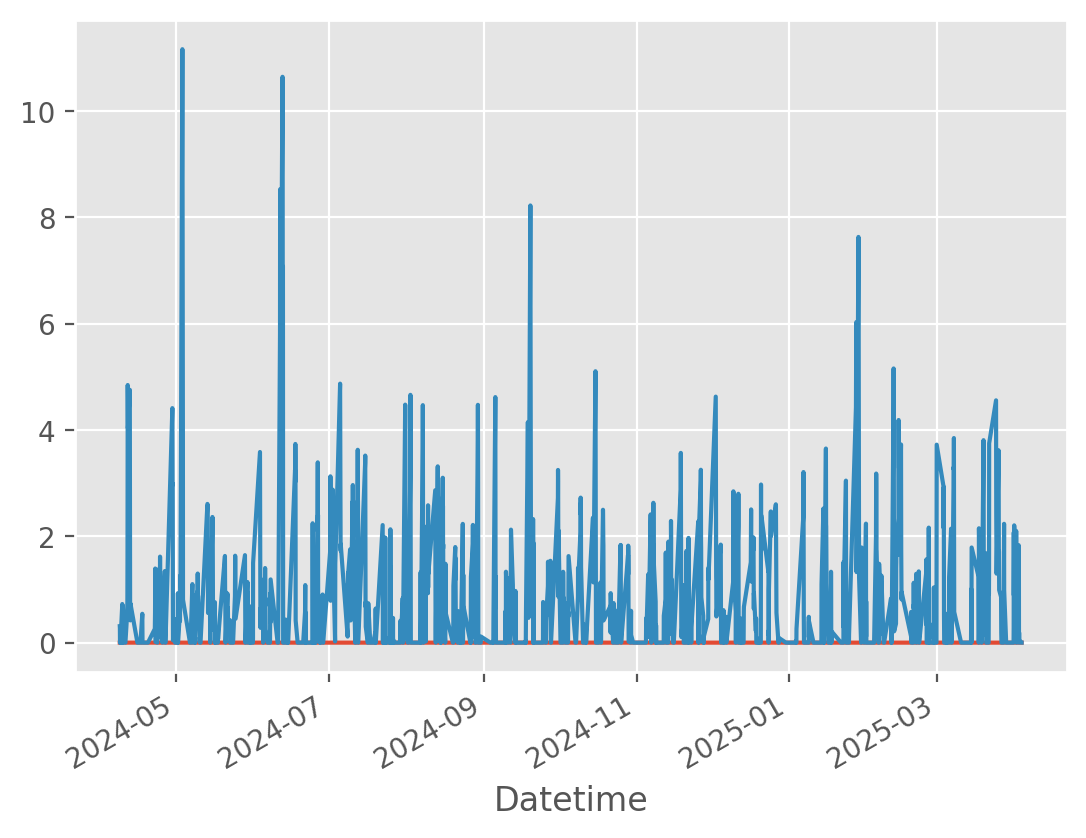

In [47]:
automatic.fit(train)
# pm_test_pred, confs = automatic.predict(n_periods=len(test), return_conf_int=True)
automatic.predict_in_sample().plot()
train.plot()


/opt/anaconda3/envs/datascience/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


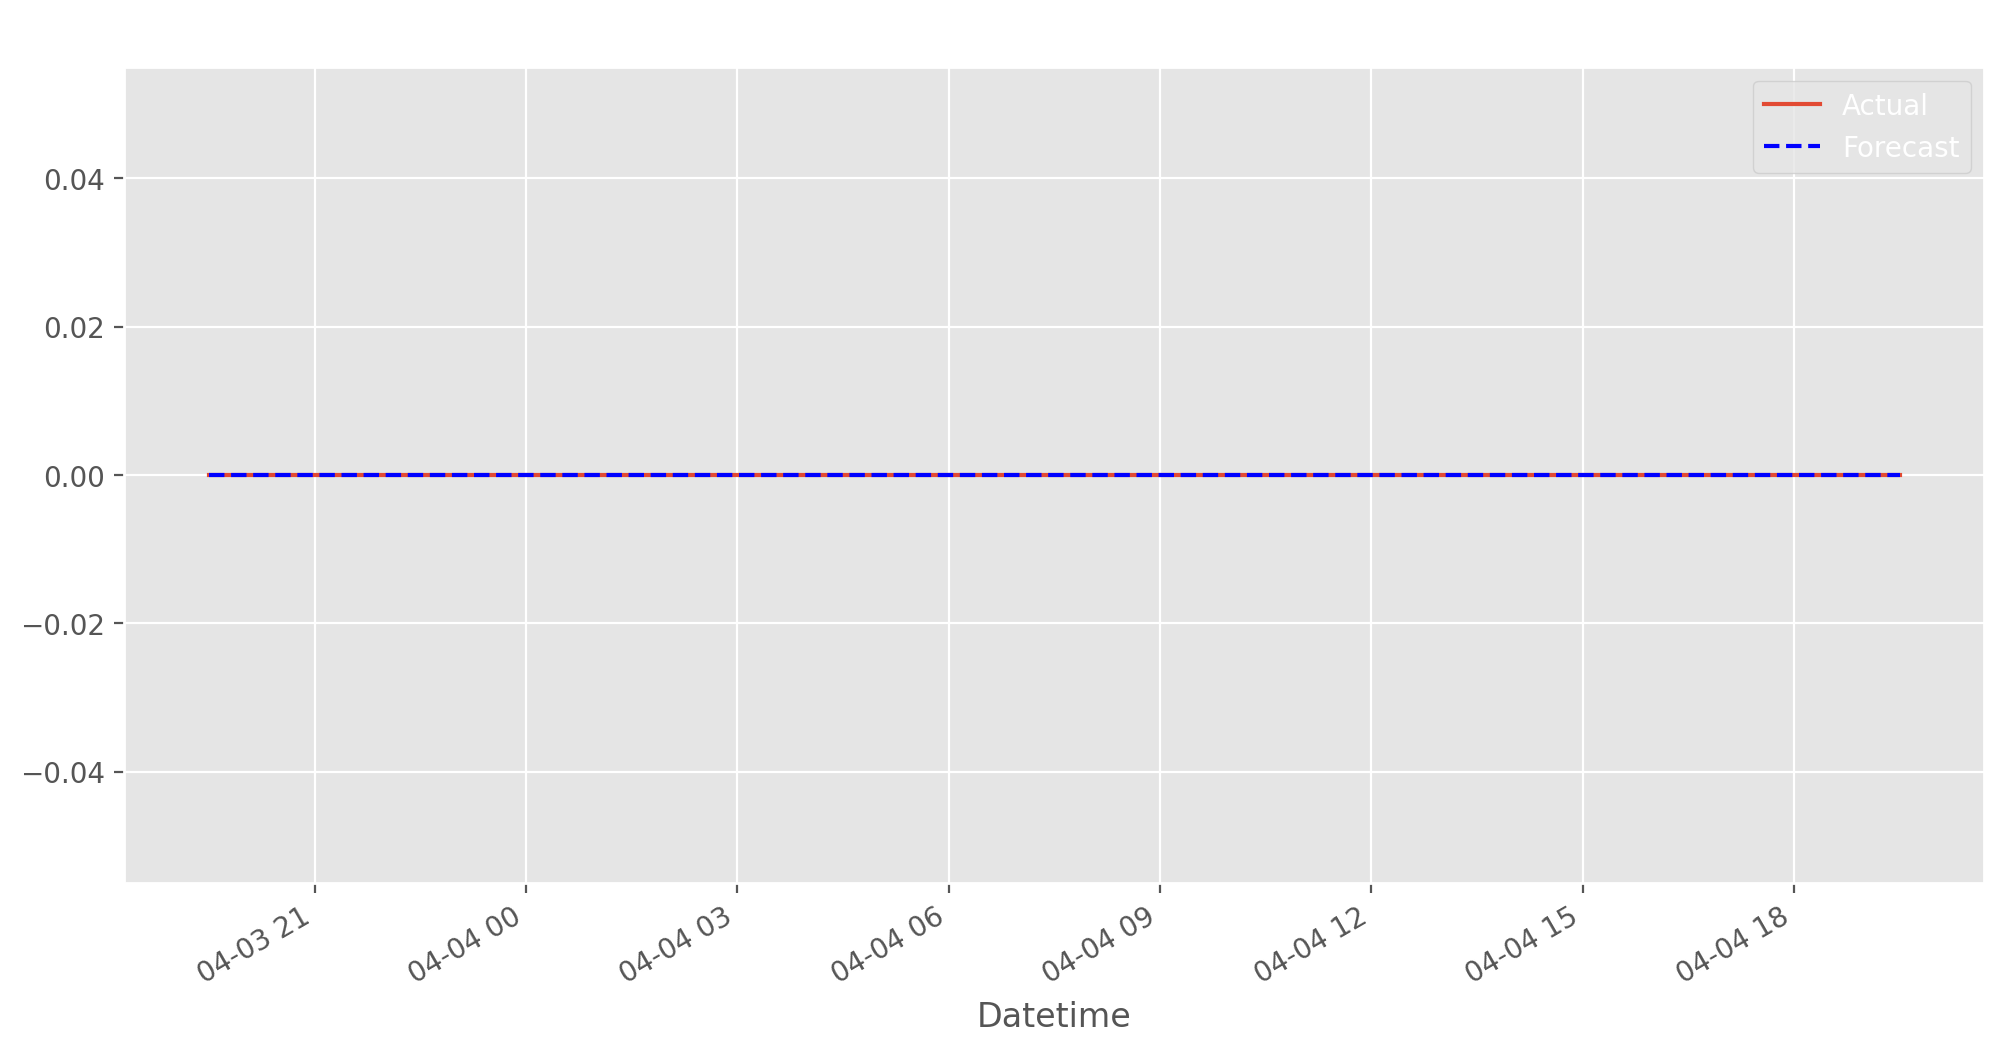

<Figure size 640x480 with 0 Axes>

In [48]:
auto_forecast = automatic.predict(y=test, n_periods=len(test))
auto_forecast.index = test.index
auto_test_results = pd.DataFrame(
    {"test": test, 
    "forecast": auto_forecast}, index=test.index
)

# Plot actual vs predicted values
fig, ax = plt.subplots(figsize=(12, 6))
auto_test_results["test"].plot(label="Actual", ax=ax)
auto_test_results["forecast"].plot(label="Forecast", ax=ax, style="--", color="blue")

plt.title("AUTOARIMA Forecast vs Actual Values")
plt.legend()
plt.show()
plt.tight_layout();

In [49]:
from prophet import Prophet
import pandas as pd
import matplotlib.pyplot as plt

# Initialize and fit Prophet model
m = Prophet(yearly_seasonality=True, 
           weekly_seasonality=True, 
           daily_seasonality=True)

# Prepare training data for Prophet
prophet_train = train.reset_index()
prophet_train.columns = ["ds", "y"]

# Remove timezone information from the 'ds' column
prophet_train['ds'] = prophet_train['ds'].dt.tz_localize(None)

m.fit(prophet_train)

# Create future dataframe with test dates
if not test.empty:
    future = pd.DataFrame(test.index, columns=['ds'])
    future['ds'] = pd.to_datetime(future['ds'])  # Ensure 'ds' is datetime
    future['ds'] = future['ds'].dt.tz_localize(None)

    forecast = m.predict(future)

    # Extract the forecast values and store them
    forecast = pd.Series(forecast['yhat'].values, index=test.index)

    # Plot the results
    fig, ax = plt.subplots(figsize=(12, 6))
    plt.plot(test.index, test.values, label='Test Data', color='red')
    plt.plot(test.index, forecast.values, label='Prophet Forecast', color='blue', linestyle='--')
    plt.title('Prophet Model: Actual vs Predicted')
    plt.legend(loc='best')
    plt.tight_layout()

    # Store Prophet forecast in test_results for RMSE calculation
    test_results['prophet_forecast'] = forecast
else:
    print("Test DataFrame is empty. Cannot generate forecast.")
    forecast = pd.Series()  # Assign an empty series


16:02:00 - cmdstanpy - INFO - Chain [1] start processing
16:02:00 - cmdstanpy - INFO - Chain [1] done processing


ValueError: Dataframe has no rows.

# Results

In [ ]:
print("The d = 0 root mean squared error is: ", root_mean_squared_error(test_results["test"], test_results["test_forecast_0"]))
print("The d = 1 root mean squared error is: ", root_mean_squared_error(test_results["test"], test_results["test_forecast_1"]))
print("The d = 2 root mean squared error is: ", root_mean_squared_error(test_results["test"], test_results["test_forecast_2"]))
print("The auto ARIMA root mean squared error is: ", root_mean_squared_error(auto_test_results["test"], auto_test_results["forecast"]))
print("The Prophet root mean squared error is: ", root_mean_squared_error(test_results["test"], forecast))
print(f"The max p is {p+1}")
print(f"The max q is {q+1}")

In [ ]:
# Save timestamp, prediction and actual price to a database